In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.10.0


In [2]:
# Lets build a dictionary to mantain our char labels in memory. 
LABEL_STR = {0.0: 'A', 1.0: 'C', 2.0: 'F', 3.0: 'H', 4.0: 'J',
             5.0: 'M', 6.0: 'P', 7.0: 'S', 8.0: 'T', 9.0: 'Y'}

In [3]:
# Loading z-normalized dataset
dataset = np.load('char_normalized_dataset.npz')
X = dataset['x']
Y = dataset['y']
print(X.shape)
print(Y.shape)

(230, 14, 1280)
(230,)


In [4]:
# Sampling data into 250ms duration with 64ms sliding increment
X_new = np.zeros((36110,32,14))
Y_new = np.zeros((36110,))
npt = 32
stride = 8
ctr = 0
for i in range(0,230):
    y = Y[i]
    a= X[i,:,:]
    a = a.transpose()
    val = 0
    while val<=(len(a)-npt):
        x = a[val:val+npt,:]
        X_new[ctr,:,:] = x
        Y_new[ctr] = y
        val = val+stride
        ctr = ctr+1

In [5]:
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=SEED)

print(f'''
X_train shape:{X_train.shape} -> Train Labels Shape: {y_train.shape}
X_test shape:{X_test.shape} -> Test Labels Shape: {y_test.shape}''')


X_train shape:(28888, 32, 14) -> Train Labels Shape: (28888,)
X_test shape:(7222, 32, 14) -> Test Labels Shape: (7222,)


In [6]:
# Creating architecture

i1 = Input(shape=(32,14))
x1 = BatchNormalization()(i1)
x1 = Conv1D(128, kernel_size=10, strides=1, activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(2)(x1)
x1 = LSTM(256,activation='tanh')(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
output = Dense(10, activation='softmax')(x1)

model = Model(inputs=i1, outputs=output) # summarize layers

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 14)]          0         
                                                                 
 batch_normalization (BatchN  (None, 32, 14)           56        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           18048     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 128)          512       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 128)          0         
 )                                                               
                                                             

In [7]:
# Compile and Train model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)
model.fit(X_train, y= to_categorical(y_train), validation_split=0.2,epochs=500, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/500
181/181 [==============================] - 6s 12ms/step - loss: 2.0722 - accuracy: 0.2967 - val_loss: 1.8144 - val_accuracy: 0.4588
Epoch 2/500
181/181 [==============================] - 2s 9ms/step - loss: 1.1627 - accuracy: 0.6141 - val_loss: 0.7986 - val_accuracy: 0.7463
Epoch 3/500
181/181 [==============================] - 2s 9ms/step - loss: 0.5242 - accuracy: 0.8342 - val_loss: 0.4522 - val_accuracy: 0.8467
Epoch 4/500
181/181 [==============================] - 2s 9ms/step - loss: 0.2489 - accuracy: 0.9200 - val_loss: 0.2447 - val_accuracy: 0.9214
Epoch 5/500
181/181 [==============================] - 2s 9ms/step - loss: 0.1500 - accuracy: 0.9526 - val_loss: 0.2424 - val_accuracy: 0.9259
Epoch 6/500
181/181 [==============================] - 2s 9ms/step - loss: 0.0948 - accuracy: 0.9689 - val_loss: 0.2340 - val_accuracy: 0.9320
Epoch 7/500
181/181 [==============================] - 2s 9ms/step - loss: 0.0738 - accuracy: 0.9765 - val_loss: 0.2049 - val_accuracy: 0.939

226/226 [==============================] - 1s 2ms/step

The average accuracy of the original model on Test Data is: 0.9670451398504569


<AxesSubplot:>

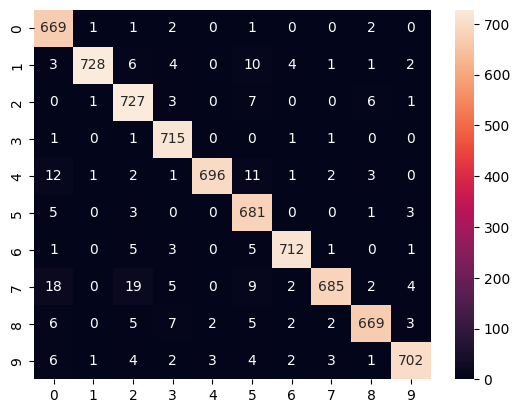

In [8]:
# Test on never-seen data
pred = model.predict(X_test)
y_pred = np.argmax(pred,axis=1)

print(f'\nThe average accuracy of the original model on Test Data is: {accuracy_score(y_pred,y_test)}')
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True ,fmt='g')